# Geospatial Data

This notebook demonstrates common workflows to analyze geospatial data such as loading geographic data in Python, geocoding, and doing simple spatial statistics. There are a ton of similarities between GeoPandas and Pandas, in fact GeoPandas can be thought of as an extension of Pandas and shares many of the same functionality. The two driving forces behind all GeoPandas operations are **GeoDataFrames** and **GeoSeries** – extensions of DataFrames and Series in Pandas. The difference is that **GeoDataFrames / GeoSeries** provide geo specific functionality enabling things such as the plotting of geometry, spatial joins, and mapping projections.

In [159]:
import geopandas as gpd
import requests
from sodapy import Socrata
import os
import pandas as pd
from shapely import wkt
from shapely.geometry import shape 
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
import numpy as np

# Loading spatial data (single file)

For this example I will load a GeoJSON file of US zip codes from the class Google drive.

In [2]:
path = '/Users/carlo/Downloads/geo_data 2/us_zipcodes.geojson'
gdf = gpd.read_file(path)

In [3]:
print(gdf.shape)
gdf.head()

(33144, 11)


,region_id,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,53922,53922,53922,B5,G6350,S,118603010,1919478,43.520930,-88.715147,"POLYGON ((-88.79170 43.53140, -88.79127 43.531..."
1,15027,15027,15027,B5,G6350,S,3728900,473269,40.666338,-80.240179,"POLYGON ((-80.25520 40.67407, -80.25538 40.673..."
2,95605,95605,95605,B5,G6350,S,10099869,434268,38.593521,-121.539867,"POLYGON ((-121.58275 38.57903, -121.58277 38.5..."
3,04468,04468,4468,B5,G6350,S,308900427,7915129,45.024673,-68.734534,"POLYGON ((-68.84231 45.09506, -68.84195 45.093..."
4,37160,37160,37160,B5,G6350,S,594479863,1466926,35.455746,-86.484790,"MULTIPOLYGON (((-86.46235 35.62683, -86.46236 ..."


# Loading spatial data (multiple files)

For this example I will load mutiple census blockgroup files downloaded from the class google drive. As this file is a CSV, we will have to do a few more steps to get the geometry data in the correct format.

<br>

### Option 1

We load the files individually as their own variable

In [106]:
path = '/Users/carlo/Downloads/blockgroup_export_000000000000.csv'
gdf_1 = pd.read_csv(path, dtype={'region_id': 'str'})

path = '/Users/carlo/Downloads/blockgroup_export_000000000001.csv'
gdf_2 = pd.read_csv(path, dtype={'region_id': 'str'})

### Converting geometry data from CSVs

The next step is to convert the geometry from the CSV file (which is read as text) to something that Python understands as geometry. To do this we can use Shapely's **wkt** object to read the text in as a [Well-known text](https://www.google.com/search?client=firefox-b-1-d&q=well+known+text) (WKT) representation of geometry.

In [107]:
gdf_1['geom'] = gdf_1['geom'].apply(wkt.loads)
gdf_2['geom'] = gdf_2['geom'].apply(wkt.loads)

<br>

Now we can convert the Pandas DataFrames to a GeoPandas GeoDataFrame

In [ ]:
gdf_1 = gpd.GeoDataFrame(gdf_1, geometry='geom', crs='epsg:4326')
gdf_2 = gpd.GeoDataFrame(gdf_2, geometry='geom', crs='epsg:4326')

<br>

Finally we can combine the GeoDataFrames using the Pandas **concat()** object.

In [109]:
# Merge / concatenate files

gdf = pd.concat([gdf_1, gdf_2])

### Option 2 (better option)

We load the files simulataneously using a **for loop**. In this option we combine all of the above steps into a single step within a for loop.

In [113]:
paths = [
    '/Users/carlo/Downloads/blockgroup_export_000000000000.csv',
    '/Users/carlo/Downloads/blockgroup_export_000000000001.csv',
    '/Users/carlo/Downloads/blockgroup_export_000000000002.csv',
    '/Users/carlo/Downloads/blockgroup_export_000000000003.csv'
]

In [117]:
results = []
for path in paths:
    temp = pd.read_csv(path, dtype={'region_id': 'str'})
    temp['geom'] = temp['geom'].apply(wkt.loads)
    results.append(gpd.GeoDataFrame(temp, geometry='geom', crs='epsg:4326'))

gdf = pd.concat(results)

# Plotting data with a GeoDataFrame

This example will download data from the US census at the zipcode level and visualize it using Geopandas. Refer to the mapping [tutorial](https://www.placedata.net/posts/mapping/) on the class website for an example using census blockgroups

In [71]:
import cenpy

In [140]:
cenn = cenpy.products.APIConnection("ACSDT5Y2018")

In [141]:
df = cenn.query(['B19013_001E'], geo_unit='zip code tabulation area')

In [142]:
df['B19013_001E'] = df['B19013_001E'].astype(float)

<br>

By default, the census data sets missing values to -666666666.0. The below line of code changes this to the more conventional NaN, so its easier for Pandas to remove the missing rows.

In [161]:
df.replace(-666666666.0, np.nan, inplace=True)

In [162]:
df.dropna(inplace=True)

In [163]:
print(df.shape)
df.head()

(30891, 2)


,B19013_001E,zip code tabulation area
0,13092.0,00601
1,16358.0,00602
2,16603.0,00603
3,12832.0,00606
4,19309.0,00610


In [151]:
# load zip code geometry
path = '/Users/carlo/Downloads/geo_data 2/us_zipcodes.geojson'
gdf = gpd.read_file(path)

In [164]:
combined = gdf.merge(df, left_on='region_id', right_on='zip code tabulation area')

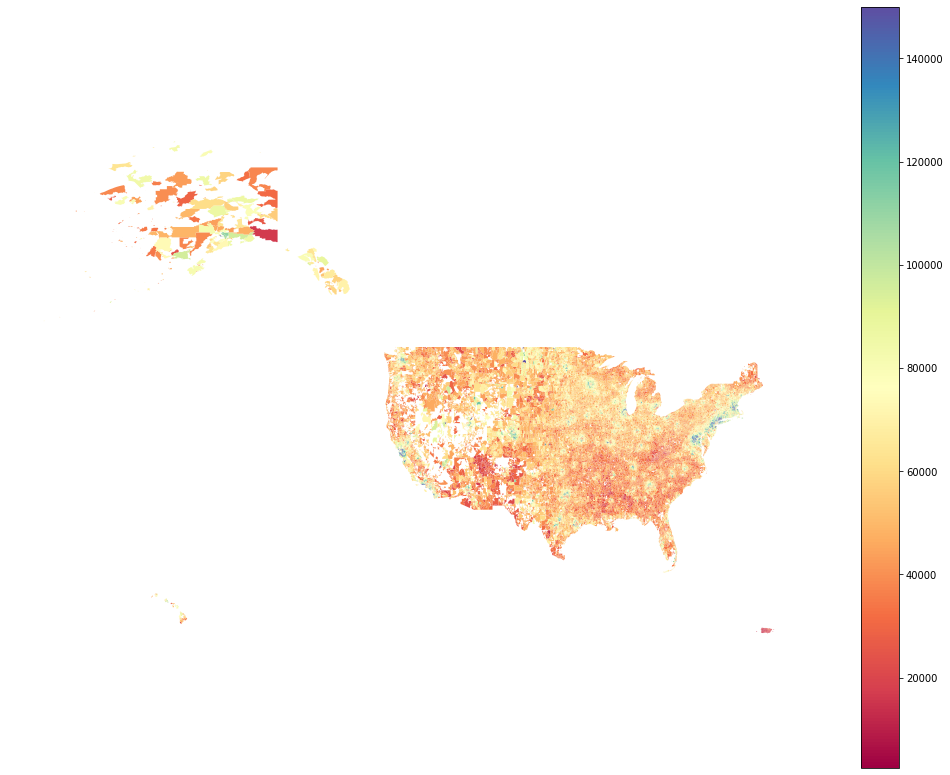

In [165]:
combined.plot(column='B19013_001E', legend=True, cmap='Spectral', vmax=150000, figsize=(18, 14))
_ = plt.axis('off')

# Coordinate Reference Systems (CRS)

The Coordinate Reference System (CRS) is an important concept in geospatial data because the geometric shapes in a GeoSeries or GeoDataFrame object are simply a collection of coordinates in arbitrary space. A CRS tells Python how those coordinates relate to places on the Earth and thus how they should appear when you plot them in a map.


## Setting the CRS

A lot of the time geographic data will already have a CRS assigned, but there are some cases when they don't and to manually assign a CRS:

In [ ]:
gdf.crs = "EPSG:4326"

To view the CRS of a GeoDataFrame

In [4]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Geocoding data with the HERE API

This example is an exact replica of the Geocoding [tutorial](https://www.placedata.net/posts/geospatial/) on the class website.

<br>

The first step is to load your HERE API credentials. You can copy and paste the codes in your notebook instead of using **os.environ** as I have below.

In [118]:
app_id = os.environ['here_app_id']
code = os.environ['here_app_code']

Next you specify your *search* address

In [119]:
search = '115W 18th New York, NY 10011'

Next we call the HERE API with using the Geocoding url and format the url to include our credentials and search address

In [120]:
url = "https://geocoder.api.here.com/6.2/geocode.json?app_id=%s&app_code=%s&searchtext=%s&country=USA" % (app_id, code, search)

Now we can use the requests library to download data from the url and read it in as a JSON object

In [121]:
r = requests.get(url)
features = r.json()

In [122]:
# This is what the raw data looks like
features

{'Response': {'MetaInfo': {'Timestamp': '2021-02-13T01:34:29.458+0000'},
  'View': [{'_type': 'SearchResultsViewType',
    'ViewId': 0,
    'Result': [{'Relevance': 0.92,
      'MatchLevel': 'houseNumber',
      'MatchQuality': {'Country': 1.0,
       'State': 1.0,
       'City': 1.0,
       'Street': [0.85],
       'HouseNumber': 1.0,
       'PostalCode': 1.0},
      'MatchType': 'interpolated',
      'Location': {'LocationId': 'NT_e1JSr5eaAsWrBHzTuGJn3D_xETN',
       'LocationType': 'point',
       'DisplayPosition': {'Latitude': 40.74032, 'Longitude': -73.99585},
       'NavigationPosition': [{'Latitude': 40.74023, 'Longitude': -73.99589}],
       'MapView': {'TopLeft': {'Latitude': 40.7414442,
         'Longitude': -73.9973337},
        'BottomRight': {'Latitude': 40.7391958, 'Longitude': -73.9943663}},
       'Address': {'Label': '115 W 18th St, New York, NY 10011, United States',
        'Country': 'USA',
        'State': 'NY',
        'County': 'New York',
        'City': 'New Y

In [123]:
# Now we can use the Keys to get to the Latitude and Longitude values
view = features['Response']['View'][0]
pt = view['Result'][0]['Location']['DisplayPosition']
lat = pt['Latitude']
lng = pt['Longitude']

In [124]:
lat, lng

(40.74032, -73.99585)